# Chapter 2 -  Small and Large Worlds.

Thanks to ecotner(https://github.com/ecotner/statistical-rethinking/) for most of the code in this book.

In [37]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

import torch
from torch import tensor as tt
import pyro
from pyro.distributions import (
    Bernoulli,
    Beta,
    Binomial,
    Categorical,
    Normal,
    Uniform,
)

In [38]:
ways = np.array([0, 3, 8, 9, 0])
print(ways/sum(ways))

[0.   0.15 0.4  0.45 0.  ]


In [39]:
# Using scipy's stats module
st.binom(n=9, p=0.5).pmf(6)

np.float64(0.16406250000000003)

## Grid Approximation

In [40]:
def calc_posterior(n_points=20):
    # Define the grid
    p_grid = np.linspace(0, 1, n_points)
    # Define uniform prior (un-normalized)
    prior = np.ones(n_points)
    # Compute likelihood at each point
    likelihood = st.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

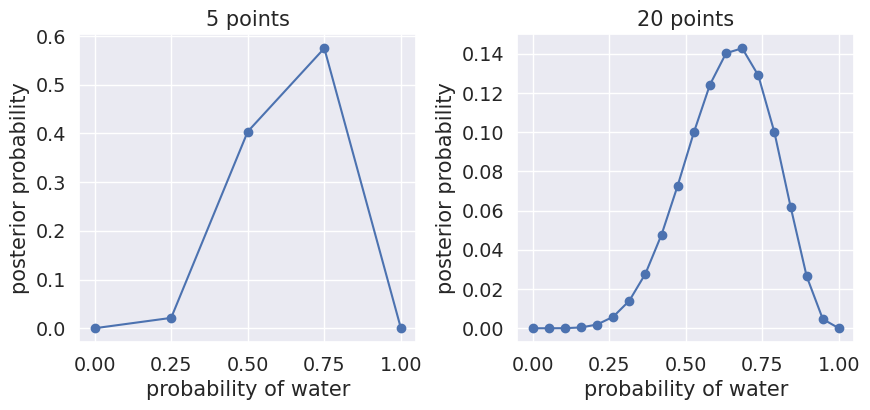

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for n, ax in zip((5, 20), axes):
    p_grid, posterior = calc_posterior(n)
    ax.plot(p_grid, posterior, marker="o")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{n} points")
plt.subplots_adjust(wspace=0.3)
plt.show()

In [26]:
def calc_posterior(prior):
    # Define the grid
    n_points = len(prior)
    p_grid = np.linspace(0, 1, n_points)
    # Compute likelihood at each point
    likelihood = st.binom(n=9, p=p_grid).pmf(6)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

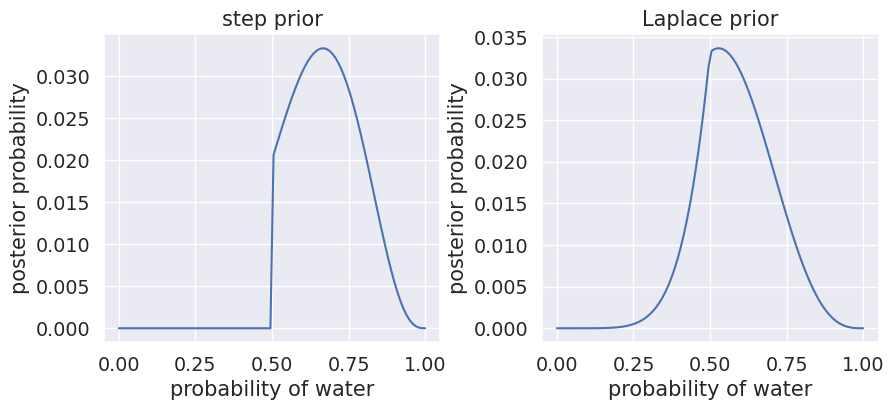

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
n_points = 100
p_grid = np.linspace(0, 1, n_points)
priors = np.array([
    [0 if p < 0.5 else 1 for p in p_grid], # step function
    np.exp(-5*np.abs(p_grid - 0.5)), # Laplace prior
])
for prior, ax, label in zip(priors, axes, ("step", "Laplace")):
    p_grid, posterior = calc_posterior(prior)
    ax.plot(p_grid, posterior)
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(f"{label} prior")
plt.subplots_adjust(wspace=0.3)
plt.show()

## Quadratic Approxmiation

In [30]:

# First, we compute the MAP estimate
pyro.clear_param_store()
# Specify the model
def model(W, L):
    N = tt(W+L)
    # p is an optimizable parameter instead of a sampled value
    p = pyro.param("p", Uniform(0., 1.).sample())
    # Condition on the observed value of W
    pyro.sample("W", Binomial(N, p), obs=tt(W))

# Trace the model so that we can inspect it when it runs
traced_model = pyro.poutine.trace(model)
vals = []
# Use vanilla gradient descent to maximize the likelihood
for _ in range(1000):
    tr = traced_model.get_trace(6., 3.)
    p = tr.nodes["p"]["value"]
    log_L = tr.log_prob_sum() # log likelihood
    log_L.backward() # Differentiate likelihood wrt parameters (p)
    p.data += 1e-3*p.grad # gradient update
    p.grad.zero_()
    vals.append(p.item())
print(f"MAP estimate: p={vals[-1]:.4f}")


MAP estimate: p=0.6667


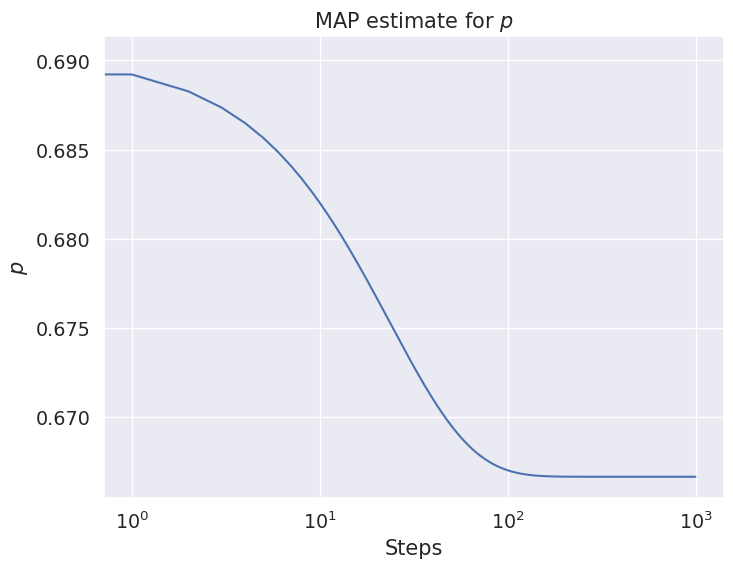

In [31]:
plt.plot(vals)
plt.xscale('log')
plt.title("MAP estimate for $p$")
plt.xlabel("Steps")
plt.ylabel("$p$")
plt.show()

In [33]:
# Compute the "curvature" (second derivative) of the log
# likelihood wrt p
tr = traced_model.get_trace(6., 3.)
p = tr.nodes["p"]["value"]
log_L = tr.log_prob_sum()
# Compute the second derivative of the log likelihood wrt p
g = torch.autograd.grad(log_L, p, create_graph=True)[0]
g2 = torch.autograd.grad(g, p)[0]
print(f"2nd derivative is {g2.item():.3f}")
stddev = 1/torch.sqrt(-g2)
print(f"Which means that the stddev is {stddev.item():.3f}")

2nd derivative is -40.500
Which means that the stddev is 0.157


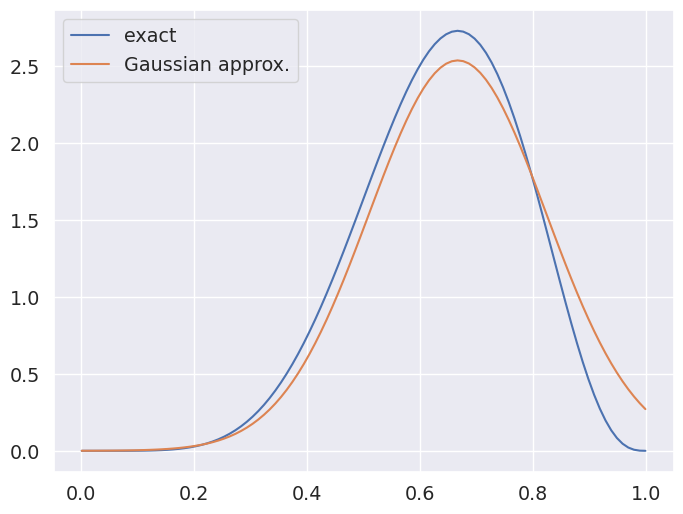

In [34]:
x = torch.linspace(0.001, 0.999, 100)
y1 = Beta(6.+1, 3.+1).log_prob(x).exp()
y2 = Normal(p, stddev).log_prob(x).exp().detach()
plt.plot(x, y1, label="exact")
plt.plot(x, y2, label="Gaussian approx.")
plt.legend()
plt.show()

## MCMC

In [35]:
n_samples = 10000
p = list()
p.append(tt(0.5))
W = tt(6.)
L = tt(3.)
for i in range(1, n_samples):
    # Take a small step away from the previous sample
    p_new = Normal(p[i-1], 0.1).sample()
    # If the step is outside [0, 1], squish it back in there
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    # Get the likelihood of the previous/current step
    q0 = Binomial(W+L, p[i-1]).log_prob(W).exp()
    q1 = Binomial(W+L, p_new).log_prob(W).exp()
    # Reject the new sample if the likelihood ratio isn't high enough
    if Uniform(0, 1).sample() < q1/q0:
        p.append(p_new)
    else:
        p.append(p[i-1])

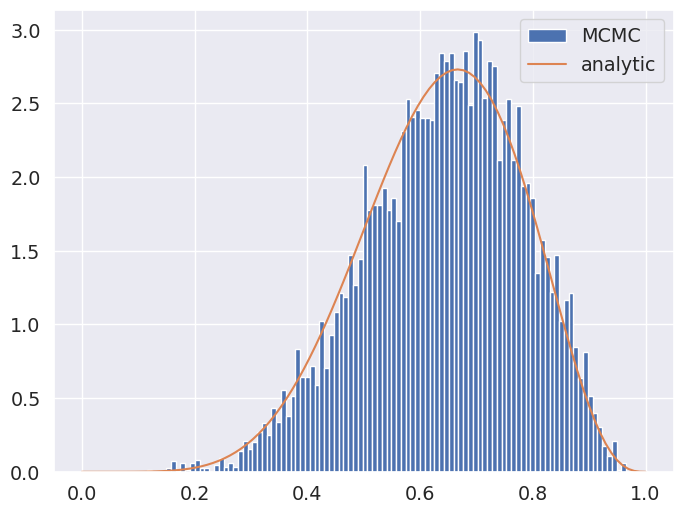

In [ ]:
plt.hist(p, bins=100, label="MCMC", density=True)
x = torch.linspace(0, 1, 100)
y = Beta(W+1, L+1).log_prob(x).exp()
plt.plot(x, y, label="analytic")
plt.legend()
plt.show()

# Exercises

### 2M1

In [52]:
def calc_posterior(W, L):
    # Define the grid
    p_grid = np.linspace(0, 1, 100)
    # Define uniform prior (un-normalized)
    prior = np.ones(p_grid.shape)
    # Compute likelihood at each point
    likelihood = st.binom(n=W+L, p=p_grid).pmf(W)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

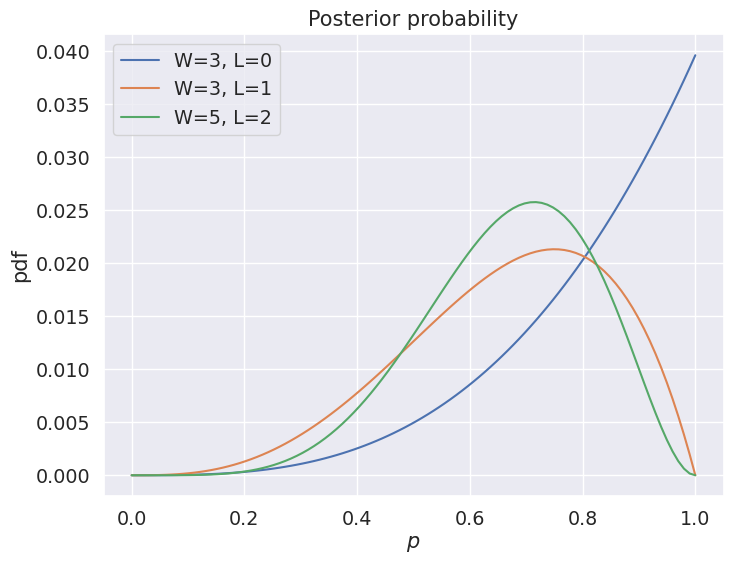

In [53]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M2

In [56]:
def calc_posterior(W, L):
    # Define the grid
    p_grid = np.linspace(0, 1, 100)
    # Define uniform prior (conditioned)
    prior = np.ones(p_grid.shape)
    prior[p_grid<0.5] = 0
    # Compute likelihood at each point
    likelihood = st.binom(n=W+L, p=p_grid).pmf(W)
    # Compute product of likelihood and prior
    posterior = likelihood * prior
    # Normalize the posterior
    posterior /= sum(posterior)
    return p_grid, posterior

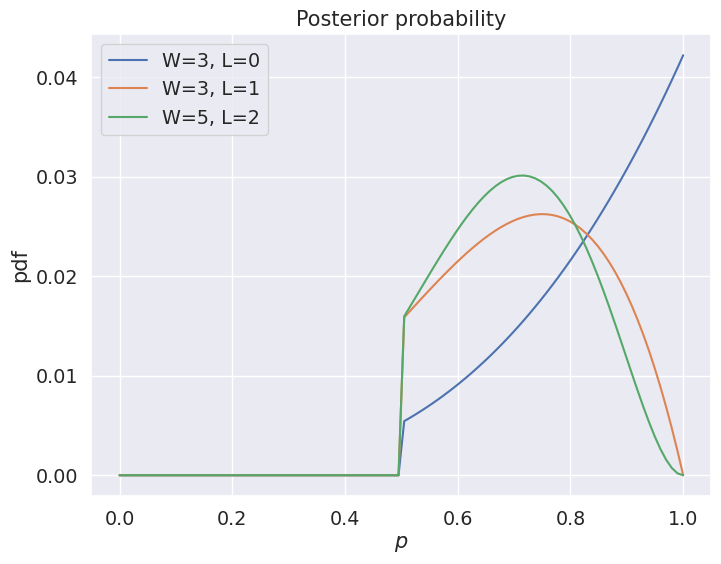

In [57]:
for W, L in ((3, 0), (3, 1), (5, 2)):
    x, y = calc_posterior(W, L)
    plt.plot(x, y, label=f"W={W}, L={L}")
plt.xlabel("$p$")
plt.ylabel("pdf")
plt.title("Posterior probability")
plt.legend()
plt.show()

### 2M3

In [58]:
def simulation(n_samples):
    # sample a planet with equal probability
    planets = np.random.choice(["earth", "mars"], n_samples)
    # toss it and see where it lands
    p = np.random.rand(n_samples)
    terrain = np.empty(n_samples, dtype=str)
    for planet, w_prob in zip(("earth", "mars"), (0.7, 0)):
        mask = (planets == planet)
        terrain[mask & (p < w_prob)] = "W"
        terrain[mask & (p >= w_prob)] = "L"
    return planets, terrain

def calc_conditional_prob():
    planets, terrain = simulation(int(1e6))
    mask = (terrain == "L")
    planets = planets[mask]
    return sum(planets == "earth")/len(planets)

In [59]:
calc_conditional_prob()

np.float64(0.23200273206811095)

Pr(Earth) = Pr(Mars) = 0.5

Pr(land|Earth) = 0.3

Pr(land|Mars) = 1

Pr(Earth|land) = Pr(Earth, land)/Pr(land)                                  
                = Pr(land|Earth)Pr(Earth)/Pr(land)                         
                = 0.3 * 0.5/Pr(land)                                       
                = 0.15/[Pr(land|Earth)Pr(Earth) + Pr(land|Mars)Pr(Mars)]   
                = 0.15/[0.3 * 0.5 + 1 * 0.5]                               
                ≈ 0.2307                                                   

### 2M4

1. Define the three cards: Black-Black (BB), Black-White (BW), and White-White (WW)
2. Prior probabilities: P(BB) = P(BW) = P(WW) = 1/3
3. We observe a black side facing up
4. Calculate likelihoods:
  - P(black up | BB) = 1
  - P(black up | BW) = 1/2
  - P(black up | WW) = 0
5. Calculate total probability of seeing black up:
  P(black up) = 1 × 1/3 + 1/2 × 1/3 + 0 × 1/3 = 1/3 + 1/6 = 1/2
6. Apply Bayes' theorem to find P(BB | black up):
  P(BB | black up) = P(black up | BB) × P(BB) / P(black up)
  P(BB | black up) = 1 × 1/3 / (1/2) = 2/3
7. Therefore, probability the other side is also black = 2/3

### 2M5

1. Define the four cards: Black-Black (BB), Black-White (BW), White-White (WW) and Black-Black (BB)
2. Prior probabilities: P(BB) = 2/4, P(BW) = 1/4 and P(WW) = 1/4
3. We observe a black side facing up
4. Calculate likelihoods:
  - P(black up | BB) = 1
  - P(black up | BW) = 1/2
  - P(black up | WW) = 0
5. Calculate total probability of seeing black up:
  P(black up) = 1 × 2/4 + 1/2 × 1/4 + 0 × 1/4 = 1/2 + 1/8 = 5/8
6. Apply Bayes' theorem to find P(BB | black up):
  P(BB | black up) = P(black up | BB) × P(BB) / P(black up)
  P(BB | black up) = 1 × 1/2 / (5/8) = 4/5
7. Therefore, probability the other side is also black = 4/5

### 2M6

1. Define the three cards: Black-Black (BB), Black-White (BW), and White-White (WW)
2. Prior probabilities: P(BB) = 1/6, P(BW) = 2/6 and P(WW) = 3/6
3. We observe a black side facing up
4. Calculate likelihoods:
  - P(black up | BB) = 1
  - P(black up | BW) = 1/2
  - P(black up | WW) = 0
5. Calculate total probability of seeing black up:
  P(black up) = 1 × 1/6 + 1/2 × 2/6 + 0 × 3/6 = 1/6 + 2/12 = 1/3
6. Apply Bayes' theorem to find P(BB | black up):
  P(BB | black up) = P(black up | BB) × P(BB) / P(black up)
  P(BB | black up) = 1 × 1/6 / (1/3) = 1/2
7. Therefore, probability the other side is also black = 0.5